In [86]:
#Import#

from cellpose import models, core, io, plot
import numpy as np
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from cellpose import train
from cellpose import metrics
import imageio.v2 as imageio
import os
import skimage.filters
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage import data, img_as_float
import pandas as pd
from glob import glob
from skimage.measure import regionprops
from scipy.spatial.distance import cdist

In [64]:
#Data input from the User

folder_path = r'Y:\Group Members\Valentin Aubry\01_Data\Test_Data_Andreas_hard'  # The r in r'Example' is very important

In [65]:
# High Throughput Data Loading
Cy5_data = glob(os.path.join(folder_path, '*Cy5 SEM.tif'))
DAPI_data = glob(os.path.join(folder_path, '*DAPI SEM.tif'))
DAPI_mask_data = glob(os.path.join(folder_path, '*DAPI SEM_seg.npy'))
FITC_data = glob(os.path.join(folder_path, '*FITC SEM.tif'))
TRITC_data = glob(os.path.join(folder_path, '*TRITC SEM.tif'))


# Sorting the data in case it isn't yet
Cy5_data.sort()
DAPI_data.sort()
DAPI_mask_data.sort()
FITC_data.sort()
TRITC_data.sort()


# Displaying all the data that was loaded
for i in range (len(DAPI_data)):
    print(os.path.basename(Cy5_data[i]))
    print(os.path.basename(DAPI_data[i]))
    print(os.path.basename(DAPI_mask_data[i]))
    print(os.path.basename(FITC_data[i]))
    print(os.path.basename(TRITC_data[i]))


ATR1_24h--W00032--P00015--Z00000--T00000--Cy5 SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--DAPI SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--DAPI SEM_seg.npy
ATR1_24h--W00032--P00015--Z00000--T00000--FITC SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--TRITC SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--Cy5 SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--DAPI SEM_seg.npy
ATR1_8h--W00029--P00035--Z00000--T00000--FITC SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--TRITC SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--Cy5 SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--DAPI SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--DAPI SEM_seg.npy
ATR1_UT--W00026--P00005--Z00000--T00000--FITC SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--TRITC SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--Cy5 SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM_seg.npy
ATR2_

In [11]:
#High Throughput Data Loading Loop
for i in range (len(DAPI_data)):
    #Loading the picture on i position from each channel
    Cy5_pic = imageio.imread(Cy5_data[i])
    DAPI_pic = imageio.imread(DAPI_data[i])
    DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
    FITC_pic = imageio.imread(FITC_data[i])
    TRITC_pic = imageio.imread(TRITC_data[i])

    # Extract the name of the picture that will be analyzed to later be able to save it accordingly
    base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

    # Extract the actual mask array
    masks = DAPI_mask_pic['masks']  # This contains the segmented regions

    # Function to generate a picture for every cell that cellpose recognized
    for j in range (1,len(np.unique(masks))):
        
        # Defining which nucleus from the Segmentation Mask is isolated
        cellnumber = j
        masks_reduced = (masks == cellnumber)  
    
        # Overlaying DAPI mask to TRITC
        masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  
    
        # Applying the mask to the TRITC picture by setting the background to 0 (black)
        isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
        isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)
        
        # Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
        filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, 1, high_sigma=None, mode='nearest', cval=0, channel_axis=None, truncate=4.0)

        # conversion of integer pixel values to float
        filt_img_float = img_as_float(filtered_TRITC)

        # Detecting the coordinates of the peaks
        coordinates = peak_local_max(
            filt_img_float, 
            min_distance=2,
            threshold_rel=0.25      # Only peaks above X% of brightest pixel in this picture
            # OR
            #threshold_abs=0.2       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
        )

        #Saving the peaks in a .csv file
        #Creating a .csv file containing all the coordinates of foci labbeled with each cell
        foci_data = pd.DataFrame(data=coordinates, columns=['y', 'x'])
        foci_data['cell_number'] = cellnumber



        # Praparing arguments for saving the data in a .csv
        header = False # So it doesn't add a header unless j=1
        mode = 'a'  # so it adds to an existing file that was created with the first analyzed cell at j=1
        
        if j == 1:
            header = True  # To add a header when creating the file
            mode = 'w'  # Standard mode (not adding to a file)

    

        #To add to an existing .csv file without adding headers
        foci_data.to_csv(folder_path+'/'+base_name+'DF SEM.csv', mode=mode, header=header, index=False)

In [107]:
print(len(np.unique(masks)))

177


In [119]:
picture_number = 14
cell_number = 160

#1,40 1-2   1,20  10   1,35 3  --> Detect less than obvious if possible


foci_distance_filt = 2
foci_threshold_filt = 0.8

foci_distance_unfilt = 2
foci_threshold_unfilt = 0.8

tolerance = 2


#High Throughput Data Loading Loop
#for i in range (len(DAPI_data)):
i = picture_number
#Loading the picture on i position from each channel
Cy5_pic = imageio.imread(Cy5_data[i])
DAPI_pic = imageio.imread(DAPI_data[i])
DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
FITC_pic = imageio.imread(FITC_data[i])
TRITC_pic = imageio.imread(TRITC_data[i])

# Extract the name of the picture that will be analyzed to later be able to save it accordingly
base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

# Extract the actual mask array
masks = DAPI_mask_pic['masks']  # This contains the segmented regions

# Function to generate a picture for every cell that cellpose recognized
#for j in range (1,len(np.unique(masks))):
j = cell_number

# Defining which nucleus from the Segmentation Mask is isolated
cellnumber = j
masks_reduced = (masks == cellnumber)  

# Overlaying DAPI mask to TRITC
masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  

# Applying the mask to the TRITC picture by setting the background to 0 (black)
isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)

# Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, low_sigma=1, high_sigma=15, mode='nearest', cval=0, channel_axis=None, truncate=4.0)

# conversion of integer pixel values to float
filt_img_float = img_as_float(filtered_TRITC)
img_float = img_as_float(isolated_TRITC)

# Detecting the coordinates of the peaks
coordinates_filtered = peak_local_max(
    filt_img_float, 
    min_distance=foci_distance_filt,
    threshold_rel=foci_threshold_filt      # Only peaks above X% of brightest pixel in this picture
    # OR
    #threshold_abs=0.2       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)

# Detecting the coordinates of the peaks
coordinates_unfiltered = peak_local_max(
    img_float, 
    min_distance=foci_distance_unfilt,
    threshold_rel=foci_threshold_unfilt      # Only peaks above X% of brightest pixel in this picture
    # OR
    #threshold_abs=0.2       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)




# Find foci that are close in both sets (within tolerance distance)
distances = cdist(coordinates_unfiltered, coordinates_filtered)  # calculate the distance between filtered foci and unfiltered foci
tolerance = tolerance  # pixels

# Keep foci from unfiltered that have a match in filtered
coordinates = coordinates_unfiltered[np.min(distances, axis=1) <= tolerance]  # np.min: find minimal distance between nearest foci, 
#<=tolerance: creates a boolean array with true for each unfiltered foci with a filtered one within tolerance, 
#coordinates_unfiltered[]: keeps only foci that are True












Text(0.5, 1.0, 'Orignial TRITC picture with detected peaks')

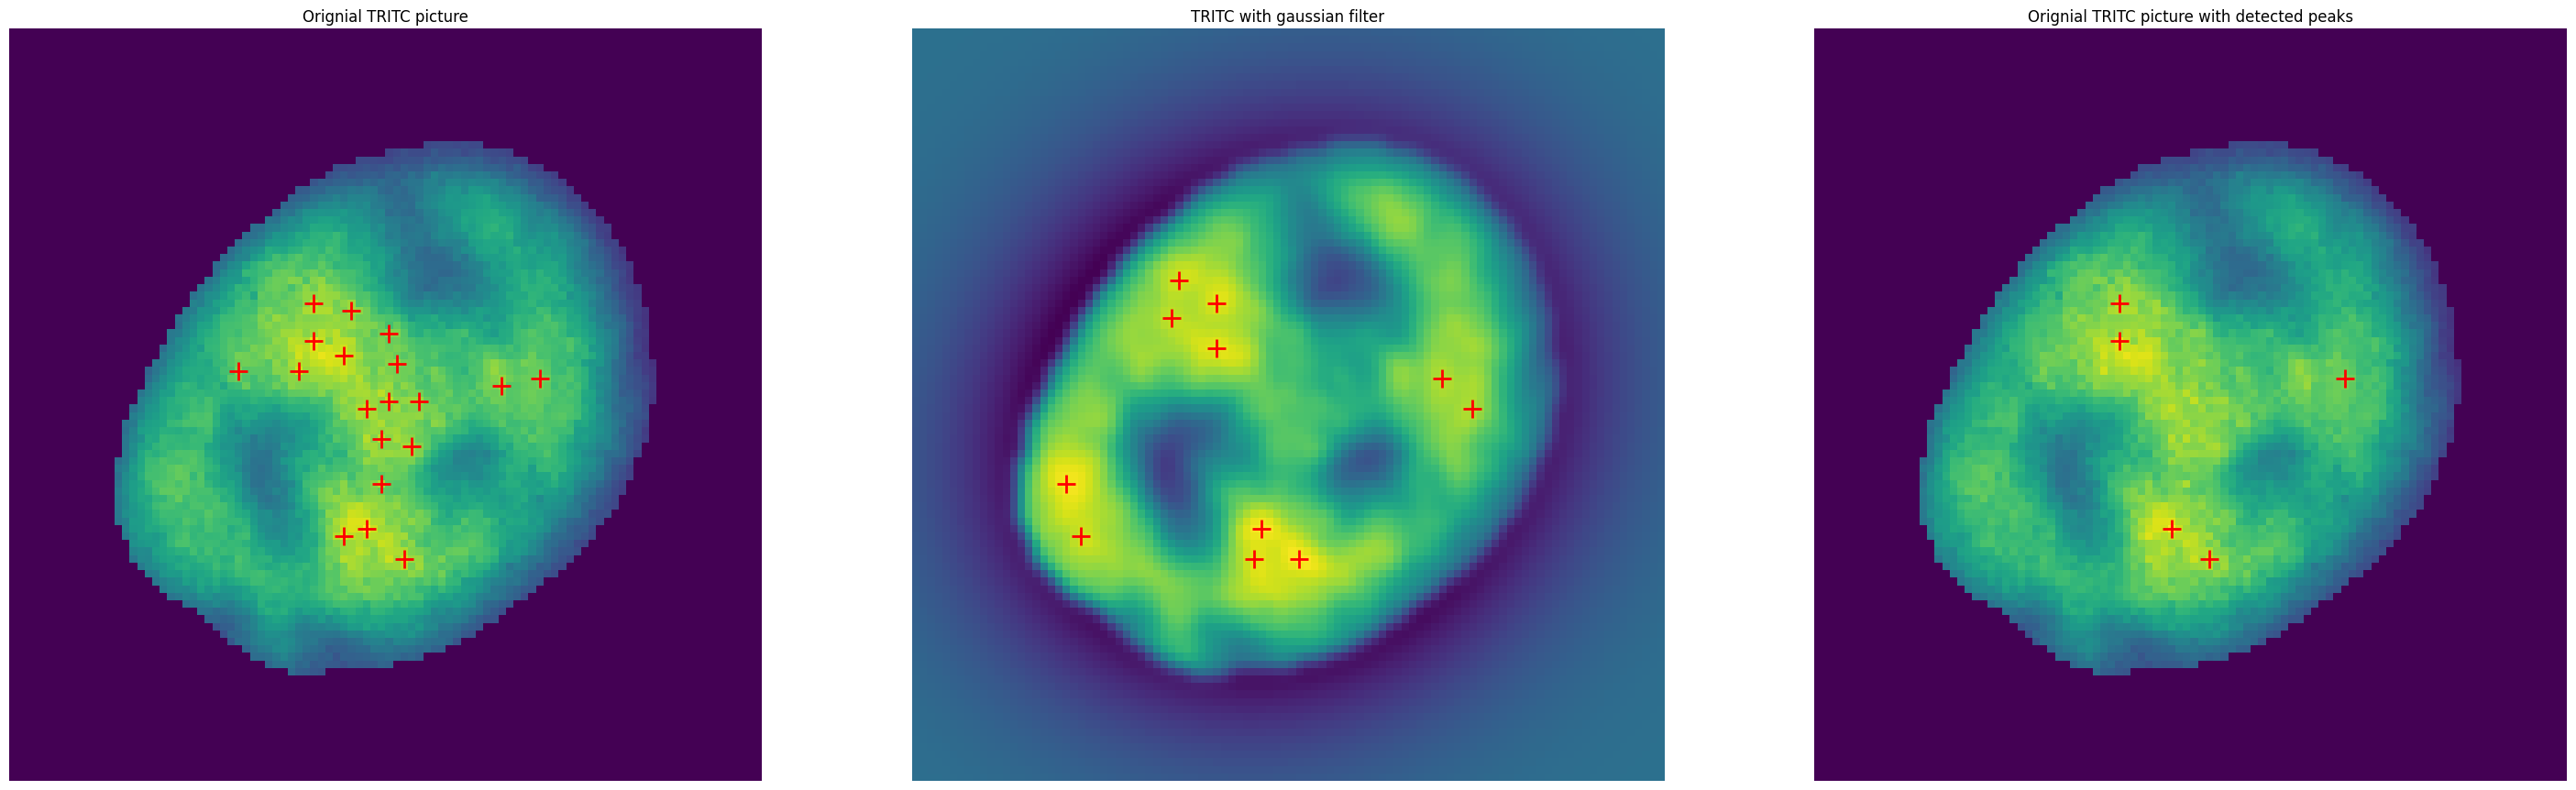

In [120]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 12))

# Finding the middle coordinates for the cell we want to look at
props = regionprops(masks_reduced.astype(int))  # Calculate region properties (centroid, area, etc.) for the cell mask
if props:  # Check if any regions (props) were found in the mask
    centroid_y, centroid_x = props[0].centroid  # Extract y and x coordinates of the cell's center, which is the only region (props[0])

# To stop the possibility of going out of boundary
if int(centroid_y) < 50:
    centroid_y = 50
if int(centroid_x) < 50:
    centroid_x = 50

# Initial crop
origin = ((int(centroid_y)-50),(int(centroid_x)-50))
#origin = (0,0)
size = (100,100) #~100x100 for single cell
#size = (2048,2048)


# Original TRITC Picture with isolated cell
axes[0].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_unfiltered = coordinates_unfiltered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_unfiltered[:, 0] >= 0) & (adjusted_unfiltered[:, 0] < size[0]) & \
       (adjusted_unfiltered[:, 1] >= 0) & (adjusted_unfiltered[:, 1] < size[1])
visible_unfiltered = adjusted_unfiltered[mask]

# Plot the peaks
axes[0].plot(visible_unfiltered[:, 1], visible_unfiltered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[0].axis('off')
axes[0].set_title('Orignial TRITC picture')

# Filtered TRITC picture with isolated cell
axes[1].imshow(filtered_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]]) 

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_filtered = coordinates_filtered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_filtered[:, 0] >= 0) & (adjusted_filtered[:, 0] < size[0]) & \
       (adjusted_filtered[:, 1] >= 0) & (adjusted_filtered[:, 1] < size[1])
visible_filtered = adjusted_filtered[mask]

# Plot the peaks
axes[1].plot(visible_filtered[:, 1], visible_filtered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[1].axis('off')
axes[1].set_title('TRITC with gaussian filter')

# Original TRITC Picture with isolated cell
axes[2].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_coords = coordinates - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_coords[:, 0] >= 0) & (adjusted_coords[:, 0] < size[0]) & \
       (adjusted_coords[:, 1] >= 0) & (adjusted_coords[:, 1] < size[1])
visible_coords = adjusted_coords[mask]

# Plot the peaks
axes[2].plot(visible_coords[:, 1], visible_coords[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[2].axis('off')
axes[2].set_title('Orignial TRITC picture with detected peaks')


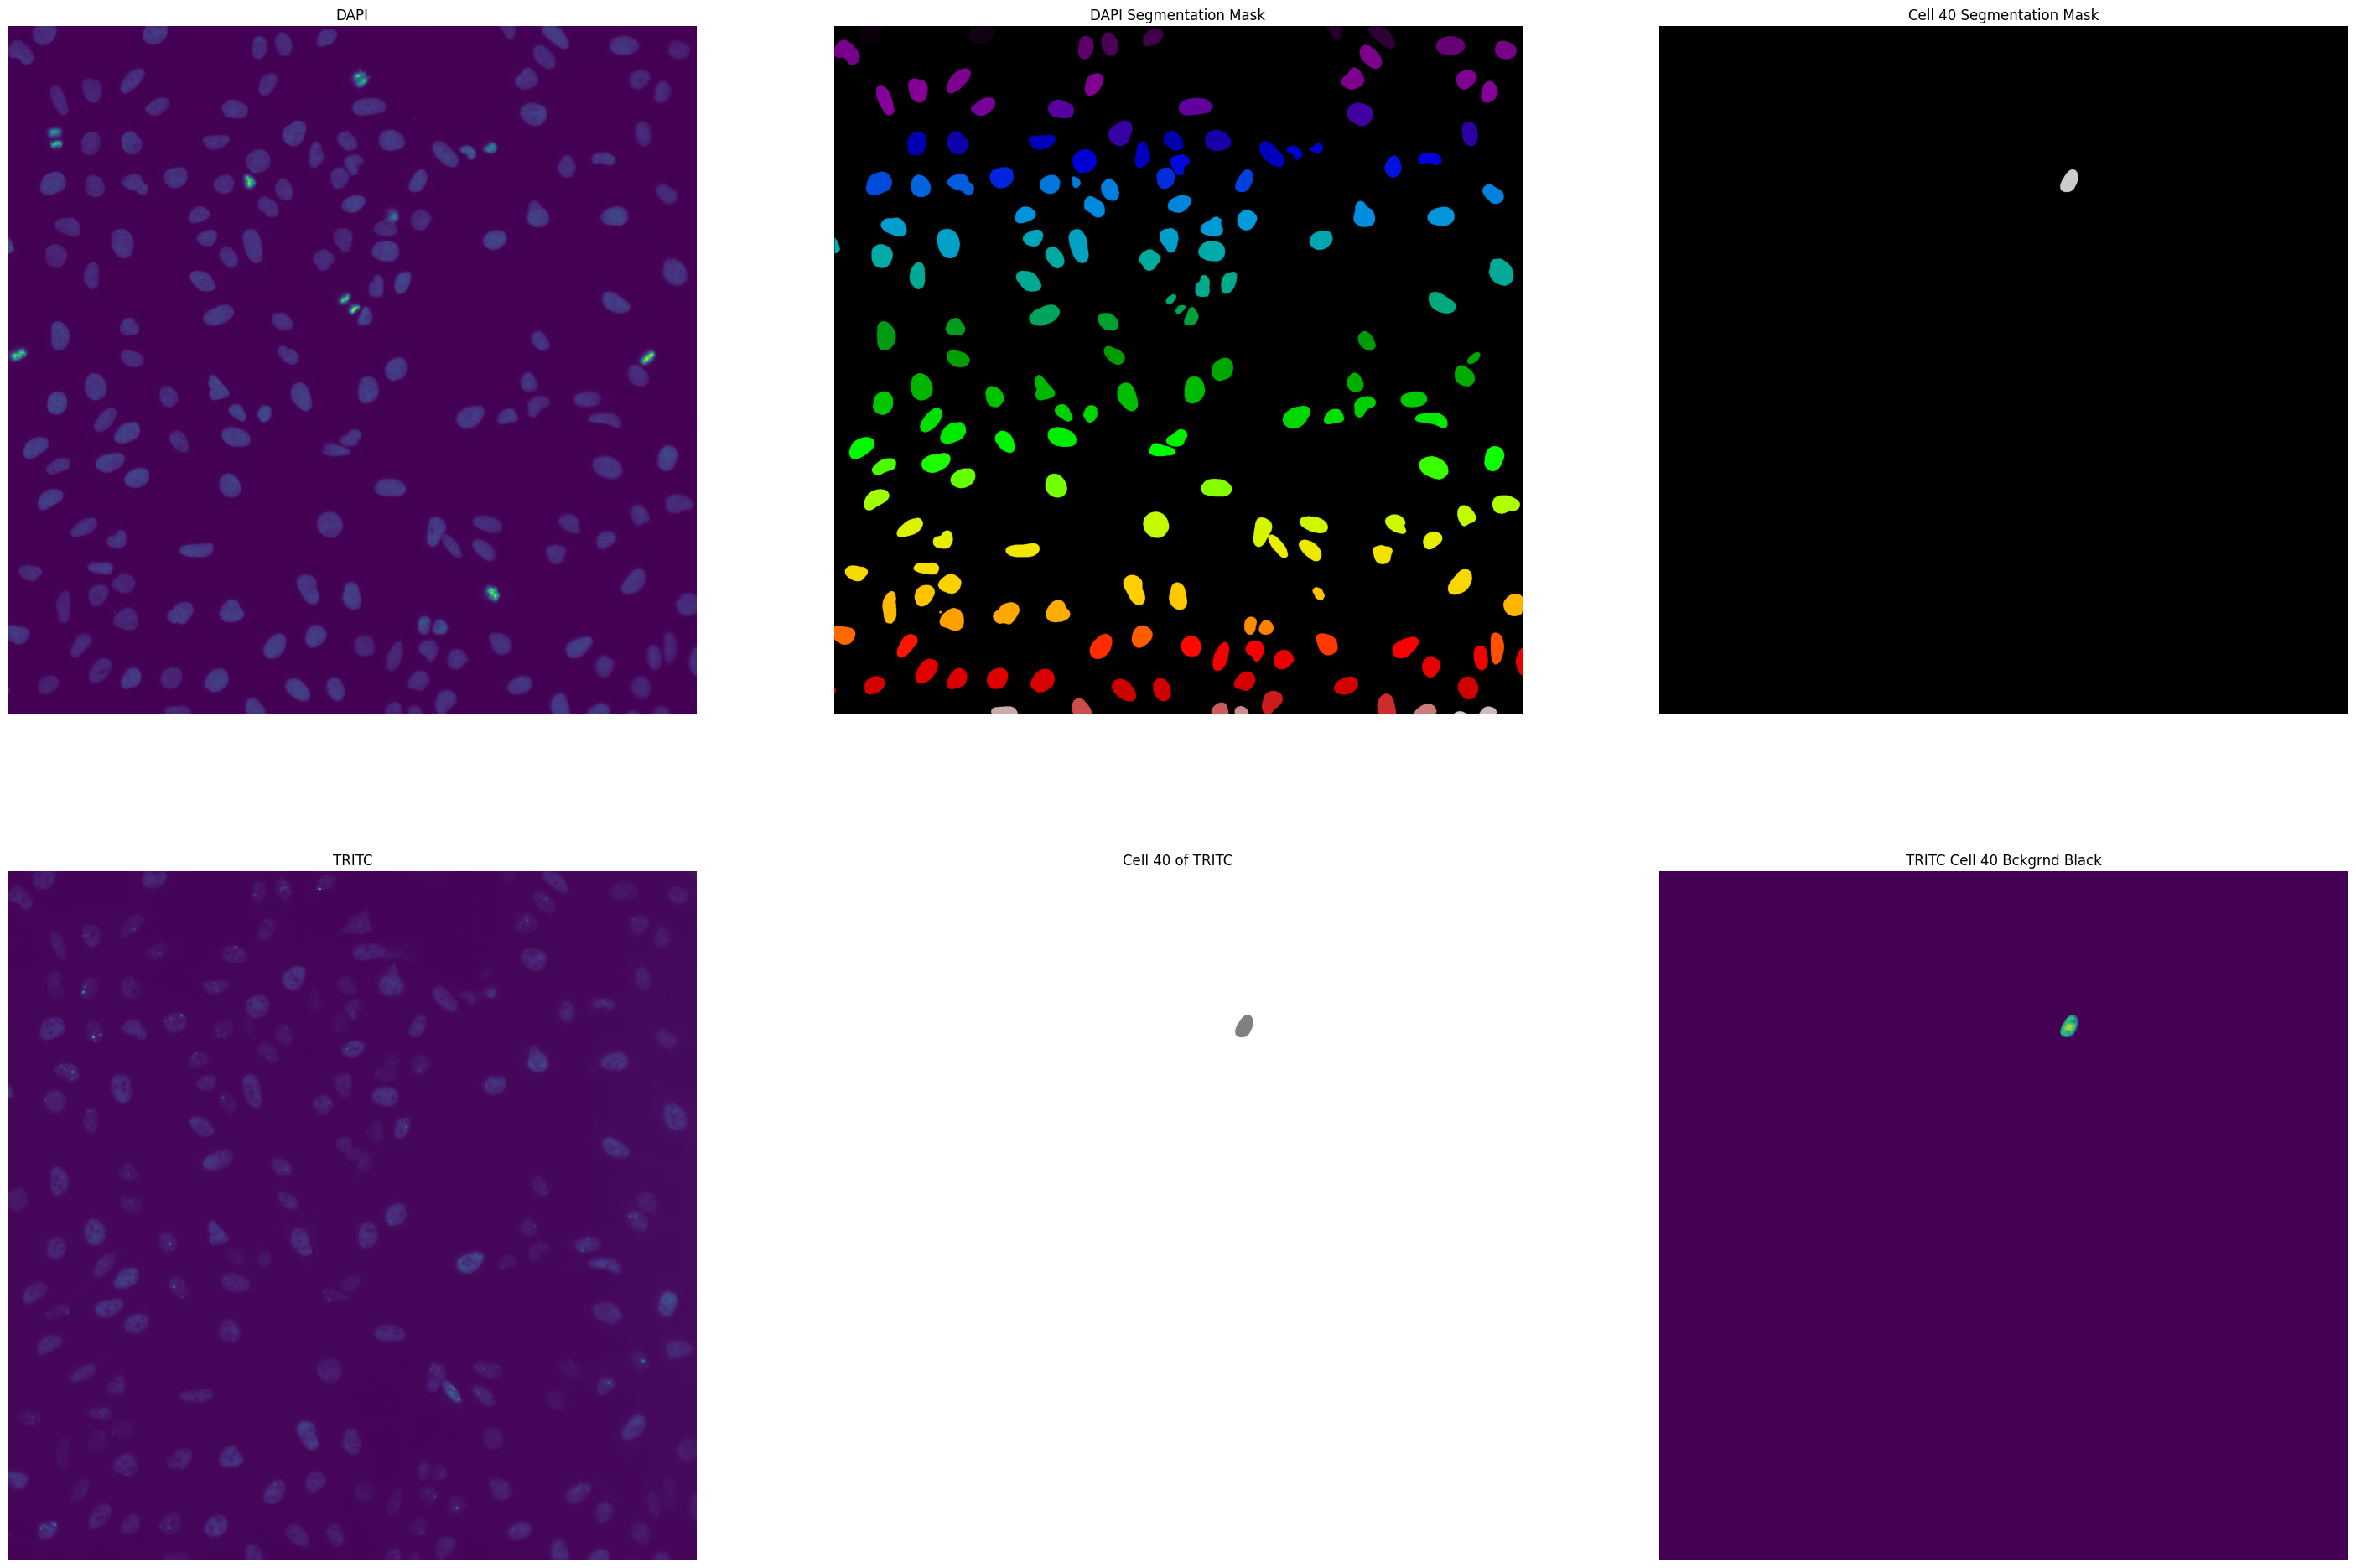

In [85]:
# Plotting Masks
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 24))

# Original DAPI Picture
axes[0,0].imshow(DAPI_pic)
axes[0,0].axis('off')
axes[0,0].set_title('DAPI')

# Full Segmentation Mask
axes[0,1].imshow(masks, cmap='nipy_spectral') 
axes[0,1].axis('off')
axes[0,1].set_title('DAPI Segmentation Mask')

# Singular Nucleus isolated from Mask
axes[0,2].imshow(masks_reduced, cmap='nipy_spectral')
axes[0,2].axis('off')
axes[0,2].set_title('Cell 40 Segmentation Mask')

# Original TRITC Picture
axes[1,0].imshow(TRITC_pic)
axes[1,0].axis('off')
axes[1,0].set_title('TRITC')

# Mask overlaying the TRITC Picture
axes[1,1].imshow(masked_TRITC, cmap='nipy_spectral', alpha=0.5)
axes[1,1].axis('off')
axes[1,1].set_title('Cell 40 of TRITC')

#show TRITC with applied mask
axes[1,2].imshow(isolated_TRITC)
axes[1,2].axis('off')
axes[1,2].set_title('TRITC Cell 40 Bckgrnd Black')

plt.show()